**Getting the relevant data from the github.**

In [1]:
!git clone https://github.com/Sarmyt/Behavioral-Cloning

Cloning into 'Behavioral-Cloning'...
remote: Enumerating objects: 10580, done.
remote: Counting objects: 100% (10580/10580), done.
remote: Compressing objects: 100% (10579/10579), done.
remote: Total 10580 (delta 0), reused 10574 (delta 0), pack-reused 0
Receiving objects: 100% (10580/10580), 135.49 MiB | 29.54 MiB/s, done.
Checking out files: 100% (10641/10641), done.


In [0]:
!cd Behavioral-Cloning/Data

In [3]:
!ls Behavioral-Cloning/Data

driving_log.csv  IMG


**Installing the imgaug library.**

In [0]:
!pip3 install imgaug

**Importing all the relevant libraries.**

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random

Using TensorFlow backend.


**Cleaning up the data to make it more easy to work with.**

In [6]:
datadir = 'Behavioral-Cloning/Data'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

center  \
0  C:\Users\sarma\Desktop\Data\IMG\center_2018_11_28_23_31_48_107.jpg   
1  C:\Users\sarma\Desktop\Data\IMG\center_2018_11_28_23_31_48_208.jpg   
2  C:\Users\sarma\Desktop\Data\IMG\center_2018_11_28_23_31_48_314.jpg   
3  C:\Users\sarma\Desktop\Data\IMG\center_2018_11_28_23_31_48_417.jpg   
4  C:\Users\sarma\Desktop\Data\IMG\center_2018_11_28_23_31_48_523.jpg   

                                                                left  \
0   C:\Users\sarma\Desktop\Data\IMG\left_2018_11_28_23_31_48_107.jpg   
1   C:\Users\sarma\Desktop\Data\IMG\left_2018_11_28_23_31_48_208.jpg   
2   C:\Users\sarma\Desktop\Data\IMG\left_2018_11_28_23_31_48_314.jpg   
3   C:\Users\sarma\Desktop\Data\IMG\left_2018_11_28_23_31_48_417.jpg   
4   C:\Users\sarma\Desktop\Data\IMG\left_2018_11_28_23_31_48_523.jpg   

                                                                right  \
0   C:\Users\sarma\Desktop\Data\IMG\right_2018_11_28_23_31_48_107.jpg   
1   C:\Users\sarma\Desktop\Data\IMG\right_2018_11_28_23_31_48_208.jpg   
2   C:\Users\sarma\Desktop\Data\IMG\right_2018_11_28_23_31_48_314.jpg   
3   C:\Users\sarma\Desktop\Data\IMG\right_2018_11_28_23_31_48_417.jpg   
4   C:\Users\sarma\Desktop\Data\IMG\right_2018_11_28_23_31_48_523.jpg   

   steering  throttle  reverse     speed  
0  0.0       0.0       0.0      0.000082  
1  0.0       0.0       0.0      0.000082  
2  0.0       0.0       0.0      0.000082  
3  0.0       0.0       0.0      0.000082  
4  0.0       0.0       0.0      0.000082

In [7]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

center                              left  \
0  center_2018_11_28_23_31_48_107.jpg  left_2018_11_28_23_31_48_107.jpg   
1  center_2018_11_28_23_31_48_208.jpg  left_2018_11_28_23_31_48_208.jpg   
2  center_2018_11_28_23_31_48_314.jpg  left_2018_11_28_23_31_48_314.jpg   
3  center_2018_11_28_23_31_48_417.jpg  left_2018_11_28_23_31_48_417.jpg   
4  center_2018_11_28_23_31_48_523.jpg  left_2018_11_28_23_31_48_523.jpg   

                               right  steering  throttle  reverse     speed  
0  right_2018_11_28_23_31_48_107.jpg  0.0       0.0       0.0      0.000082  
1  right_2018_11_28_23_31_48_208.jpg  0.0       0.0       0.0      0.000082  
2  right_2018_11_28_23_31_48_314.jpg  0.0       0.0       0.0      0.000082  
3  right_2018_11_28_23_31_48_417.jpg  0.0       0.0       0.0      0.000082  
4  right_2018_11_28_23_31_48_523.jpg  0.0       0.0       0.0      0.000082

**Trimming the data to reduce bias towards an angle of zero degrees.**

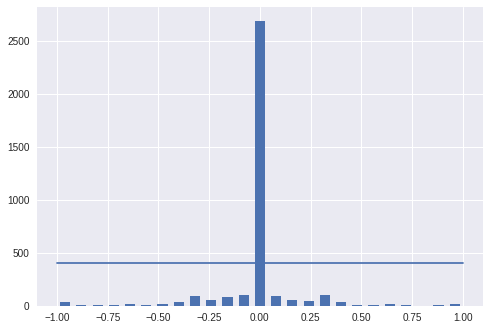

In [8]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

total data: 3546
removed: 2289
remaining: 1257


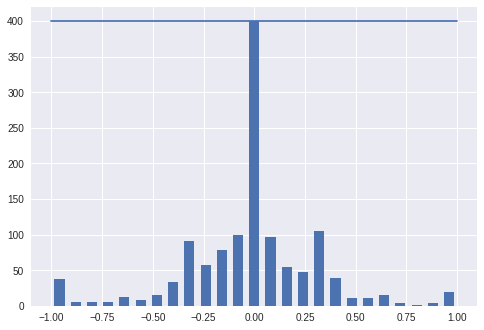

In [9]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
 
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [10]:
print(data.iloc[1])
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)

center      center_2018_11_28_23_31_49_250.jpg
left        left_2018_11_28_23_31_49_250.jpg  
right       right_2018_11_28_23_31_49_250.jpg 
steering    0                                 
throttle    0.320476                          
reverse     0                                 
speed       0.286127                          
Name: 11, dtype: object


**Splitting the data into training data and validation data for our neural network.**

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 1005
Valid Samples: 252


Text(0.5, 1.0, 'Validation set')

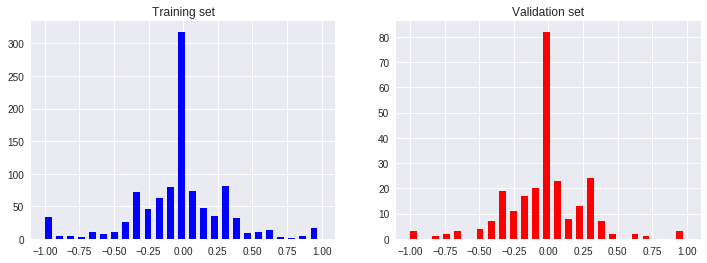

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

**Defining a function to zoom into an image for data augmentation.**

In [0]:
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image

Text(0.5, 1.0, 'Zoomed Image')

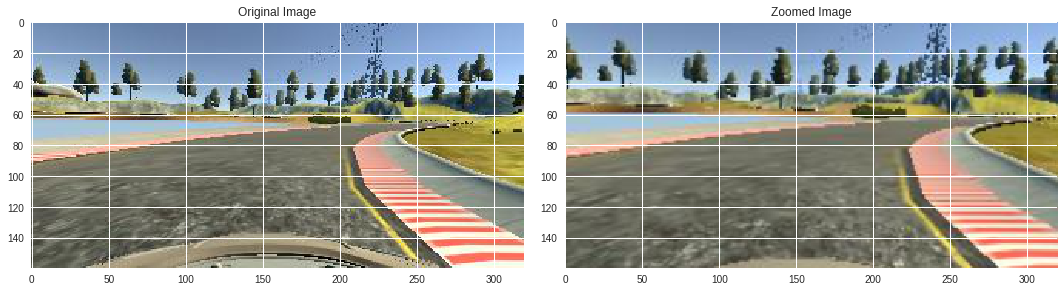

In [14]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

**Defining a function to pan around an image for data augmentation.**

In [0]:
def pan(image):
  pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image

Text(0.5, 1.0, 'Panned Image')

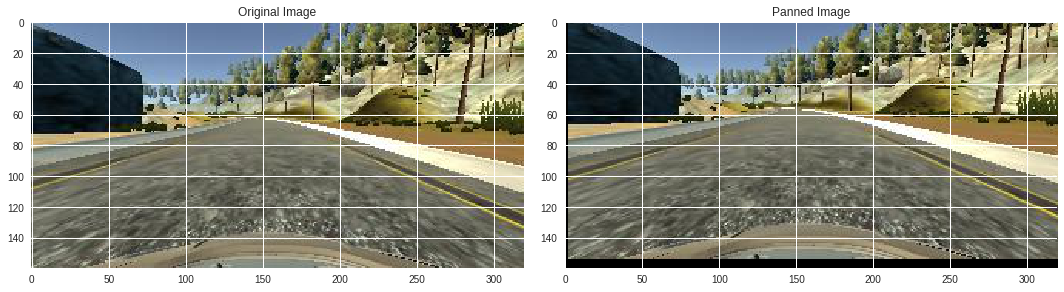

In [16]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

**Defining a function to adjust the brightness of an image for data augmentation.**

In [0]:
def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

Text(0.5, 1.0, 'Brightness altered image ')

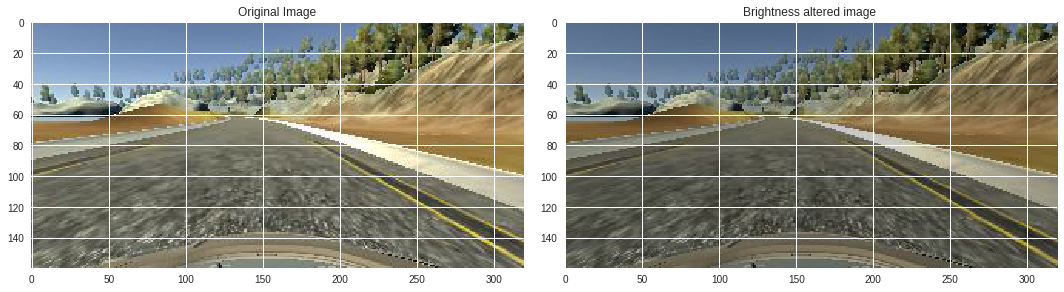

In [18]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image ')

**Defining a function to flip an image and the respective steering angle for data augmentation.**

In [0]:
def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle

Text(0.5, 1.0, 'Flipped Image - Steering Angle:0.36385120000000004')

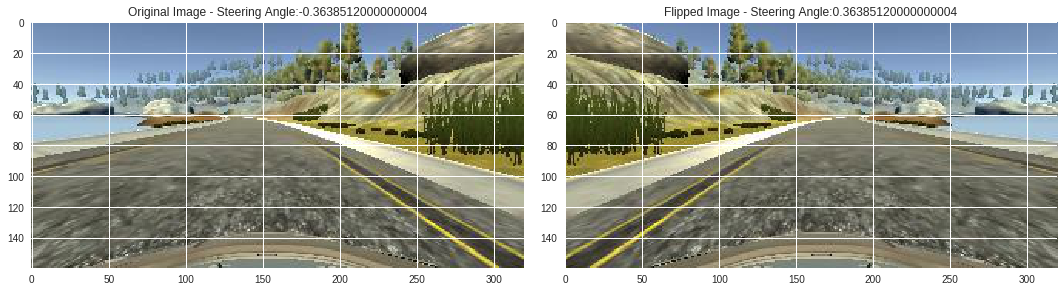

In [20]:
random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]


original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering_angle))

axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle:' + str(flipped_steering_angle))

**Defining a function to apply a 50% chance of applying a specific augmentation to an image.**

In [0]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
      image = pan(image)
    if np.random.rand() < 0.5:
      image = zoom(image)
    if np.random.rand() < 0.5:
      image = img_random_brightness(image)
    if np.random.rand() < 0.5:
      image, steering_angle = img_random_flip(image, steering_angle)
    
    return image, steering_angle

**Comparing the original image side by side its augmented counter part.**

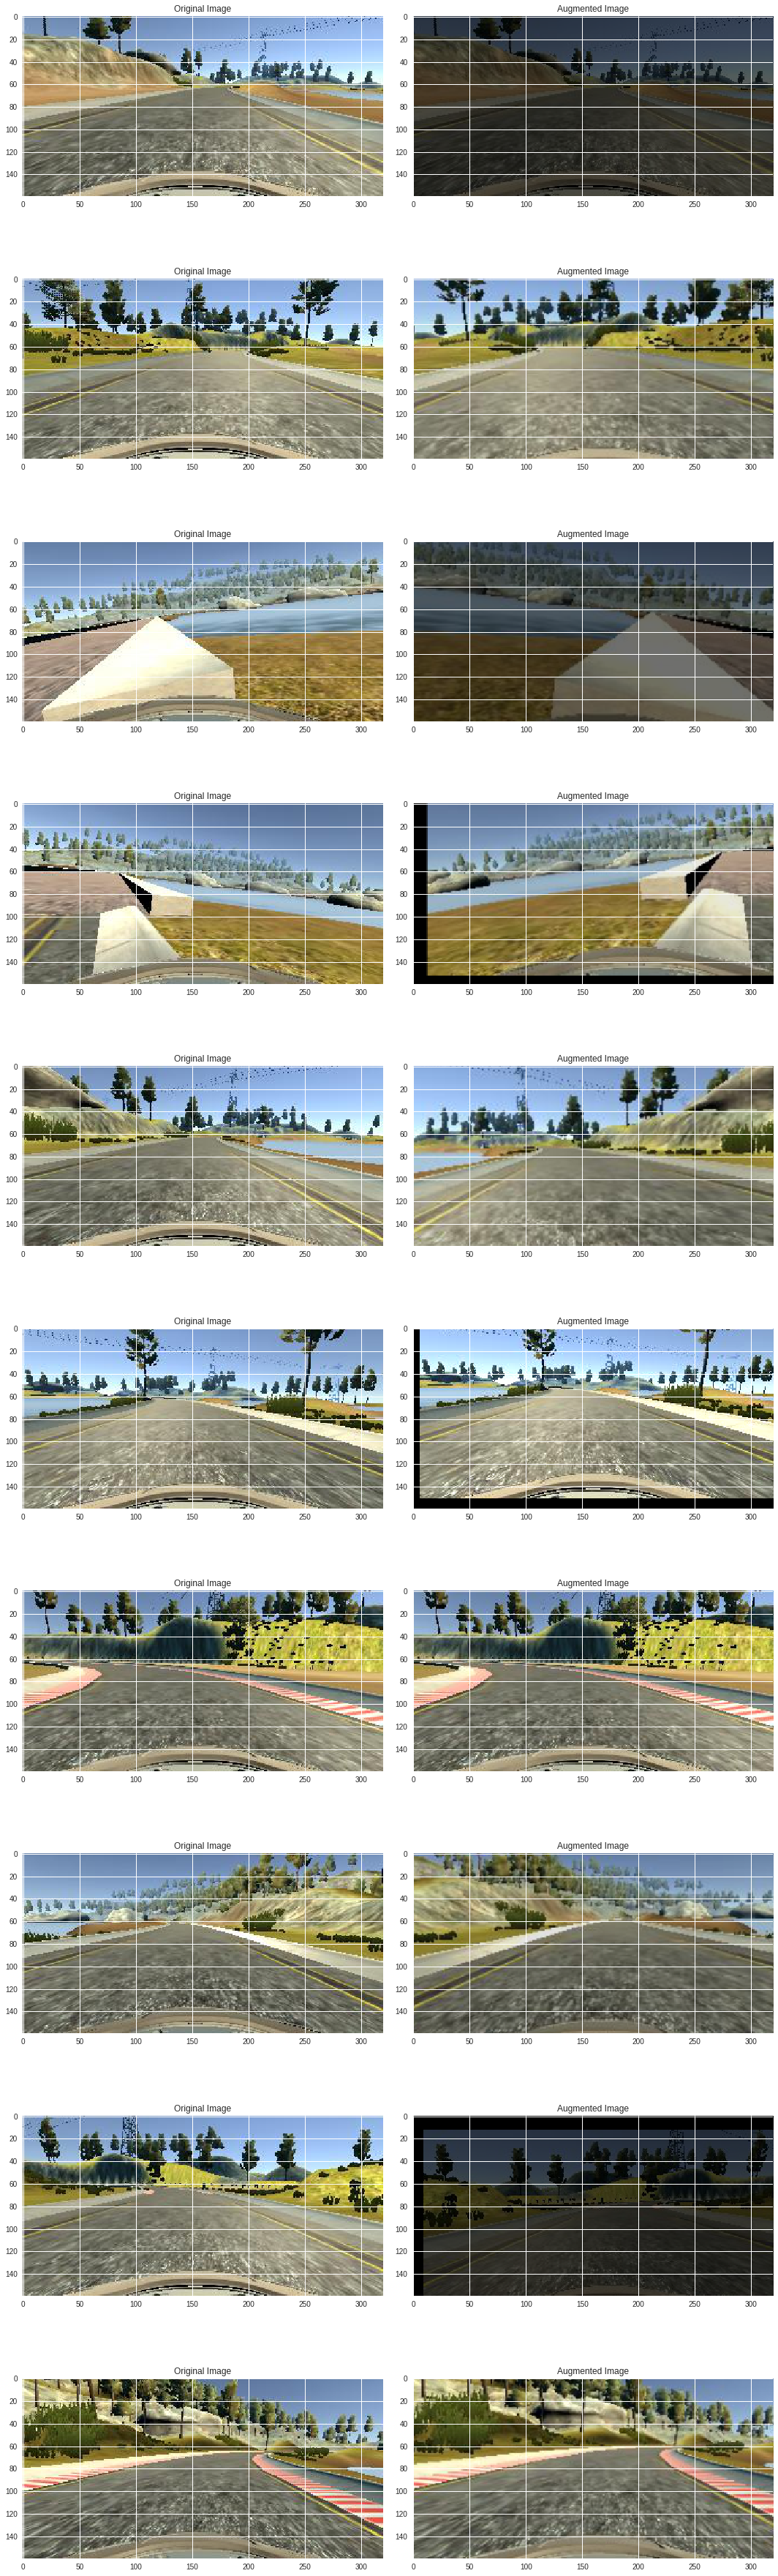

In [22]:
ncol = 2
nrow = 10

fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()

for i in range(10):
  randnum = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]
    
  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)
    
  axs[i][0].imshow(original_image)
  axs[i][0].set_title("Original Image")
  
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title("Augmented Image")

**Applying preprocessing techniques to our images.**

In [0]:
def img_preprocess(img):
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img

Text(0.5, 1.0, 'Preprocessed Image')

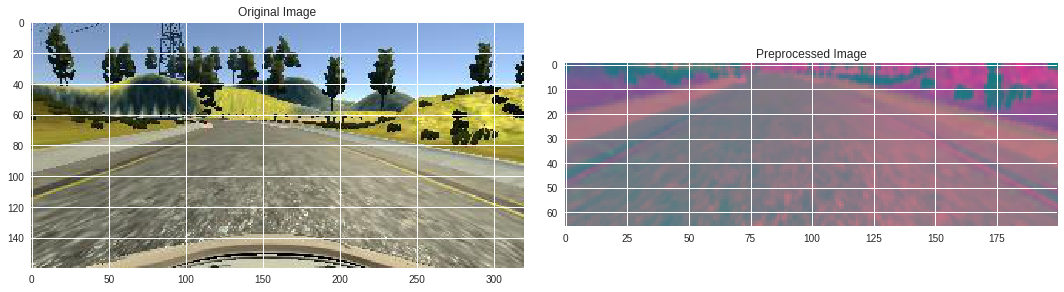

In [24]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

**Defining an image generator that will produce our augmented data set.**

In [0]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
     
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      
      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering)) 

Text(0.5, 1.0, 'Validation Image')

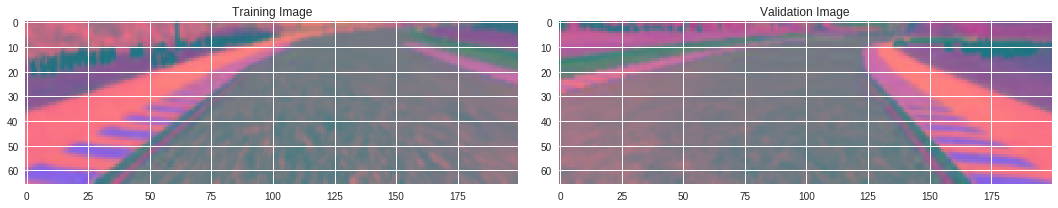

In [26]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')

axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

**Defining our convolutional neural network.**

In [0]:
def model():
  model = Sequential()
  model.add(Convolution2D(24, 5, 5, subsample=(2, 2), input_shape=(66, 200, 3), activation='elu'))
  model.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation='elu'))
  model.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation='elu'))
  model.add(Convolution2D(64, 3, 3, activation='elu'))
  
  model.add(Convolution2D(64, 3, 3, activation='elu'))
  
  model.add(Flatten())
  
  model.add(Dense(100, activation = 'elu'))
  
  model.add(Dense(50, activation = 'elu'))
  
  model.add(Dense(10, activation = 'elu'))

  model.add(Dense(1))
  
  optimizer = Adam(lr=1e-4)
  model.compile(loss='mse', optimizer=optimizer)
  return model

In [0]:
model = model()

In [29]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               115300    
__________

**Running the training process using an augmented dataset.**

In [30]:
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300, 
                                  epochs=10,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
300/300 [==============================] - 168s 560ms/step - loss: 0.1108 - val_loss: 0.0579
Epoch 2/10
300/300 [==============================] - 166s 552ms/step - loss: 0.0914 - val_loss: 0.0497
Epoch 3/10
300/300 [==============================] - 157s 525ms/step - loss: 0.0852 - val_loss: 0.0454
Epoch 4/10
300/300 [==============================] - 167s 558ms/step - loss: 0.0786 - val_loss: 0.0455
Epoch 5/10
300/300 [==============================] - 164s 547ms/step - loss: 0.0714 - val_loss: 0.0463
Epoch 6/10
300/300 [==============================] - 164s 546ms/step - loss: 0.0659 - val_loss: 0.0415
Epoch 7/10
300/300 [==============================] - 164s 547ms/step - loss: 0.0628 - val_loss: 0.0366
Epoch 8/10
300/300 [==============================] - 160s 532ms/step - loss: 0.0597 - val_loss: 0.0382
Epoch 9/10
300/300 [==============================] - 170s 567ms/step - loss: 0.0566 - val_loss: 0.0351
Epoch 10/10
300/

**Plotting the loss observed during the training process.**

Text(0.5, 0, 'Epoch')

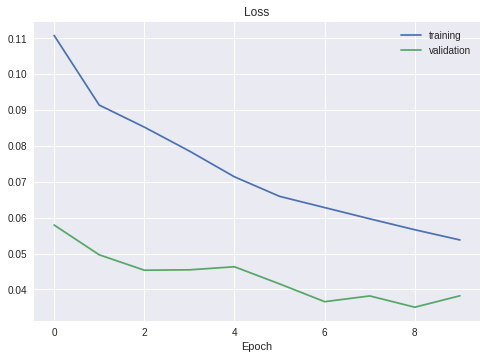

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

**Saving our trained model for use with the self driving car simulator.**

In [0]:
model.save('model.h5')

In [0]:
from google.colab import files
files.download('model.h5')